In [1]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error

import math  
import numpy as np
import pandas as pd

from tqdm.auto import tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,237,273,281,299,349,367,423,444,484,521
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,259,277,304,333,361,377,383,400,409,416
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,847,986,1171,1251,1320,1423,1468,1572,1666,1761
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,390,428,439,466,501,525,545,564,583,601
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,8,8,8,10,14,16,17,19,19,19


In [4]:
df = df.groupby(['Country/Region']).sum().reset_index(level=['Country/Region'])


In [5]:
df.head()

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20
0,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,...,237,273,281,299,349,367,423,444,484,521
1,Albania,41.1533,20.1683,0,0,0,0,0,0,0,...,259,277,304,333,361,377,383,400,409,416
2,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,...,847,986,1171,1251,1320,1423,1468,1572,1666,1761
3,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,...,390,428,439,466,501,525,545,564,583,601
4,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,...,8,8,8,10,14,16,17,19,19,19


In [6]:
dates = df.columns[4:]

df = df.melt(id_vars=[ 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Confirmed')

In [7]:
df['Date'] =pd.to_datetime(df.Date)


In [8]:
df = df[df['Country/Region'] != 'China']
df_c = df
df.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [9]:
df = df.groupby('Date')['Confirmed'].sum().reset_index()

In [10]:
df['Day num'] = np.arange(1, len(df)+1)
df.head()

,Date,Confirmed,Day num
0,2020-01-23,11,1
1,2020-01-24,21,2
2,2020-01-25,28,3
3,2020-01-26,43,4
4,2020-01-27,50,5


In [11]:
pop = pd.read_csv('datasets\population_by_country_2020.csv')
pop.head()

,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1439323776,0.39%,5540090,153,9388211,-348399.0,1.7,38,61%,18.47%
1,India,1380004385,0.99%,13586631,464,2973190,-532687.0,2.2,28,35%,17.70%
2,United States,331002651,0.59%,1937734,36,9147420,954806.0,1.8,38,83%,4.25%
3,Indonesia,273523615,1.07%,2898047,151,1811570,-98955.0,2.3,30,56%,3.51%
4,Pakistan,220892340,2.00%,4327022,287,770880,-233379.0,3.6,23,35%,2.83%


In [12]:
pop = pop[['Country (or dependency)', 'Population (2020)']].rename(columns = {'Country (or dependency)':'Country/Region',
                  'Population (2020)': 'Population'})

In [13]:
pop.head()

,Country/Region,Population
0,China,1439323776
1,India,1380004385
2,United States,331002651
3,Indonesia,273523615
4,Pakistan,220892340


# SIR model

In [14]:
# Total population, N without china
N = 6.4 *(10**9)
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.6, 1/10

In [15]:
# The SIR model differential equations.
def SIR(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


In [16]:
# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
# ret = odeint(deriv, y0, [i for i in range(1000)], args=(N, beta, gamma))
ret = odeint(SIR, y0, [i for i in range(1000)], args=(N, beta, gamma))

S, I, R = ret.T


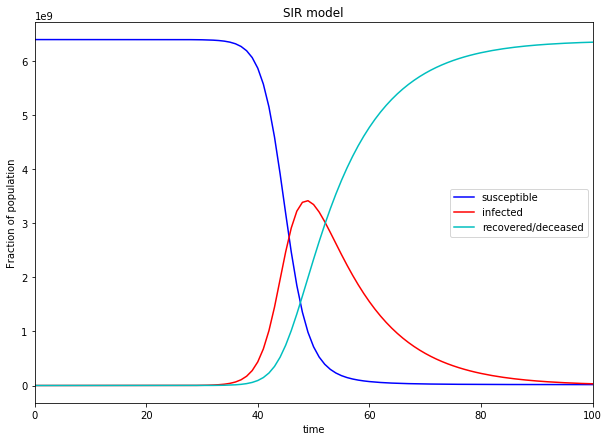

In [17]:
f = plt.figure(figsize=(10,7)) 
plt.plot(S, 'b', label='susceptible');
plt.plot(I, 'r', label='infected');
plt.plot(R, 'c', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,100)
plt.show()

In [18]:
train = 0.85
index = math.ceil(train * len(df['Confirmed'].values))
index

68

In [19]:
Y = df['Confirmed'].values
X = x = df['Day num'].values

In [20]:
y = df['Confirmed'].values[:index]
x = df['Day num'].values[:index]

N = 6.4 *(10**9)
I0, R0 = y[0], 0
S0 = N - I0 - R0

In [21]:
def opt_sir(x, beta, gamma):
    return odeint(SIR, (S0, I0, R0), x, args=(N, beta, gamma))[:,1].clip(0)

def err_sir(params, x):
    beta, gamma = params
    ret = odeint(SIR, (S0, I0, R0), x, args=(N, beta, gamma))
    S, I, R = ret.T
    I = I.clip(0)
    error = np.sqrt(mean_squared_log_error(y, I, [1/i for i in x][::-1]))
    return error
    

In [22]:
popt, pcov = optimize.curve_fit(opt_sir, x, y, bounds = [0, np.inf])

result = optimize.minimize(err_sir, popt, args=(x), method='BFGS', options={'maxiter': 500})

beta_hat = result.x
print(result)


      fun: 0.25430592235993216
 hess_inv: array([[1.08728239, 1.07048149],
       [1.07048149, 1.05395475]])
      jac: array([-0.31911655,  0.39345605])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 440
      nit: 3
     njev: 107
   status: 2
  success: False
        x: array([2.83887751, 2.67040301])


In [23]:
# pcov

In [24]:
# fitted = opt_ode(x, *popt)
fitted = opt_sir(x, *beta_hat)

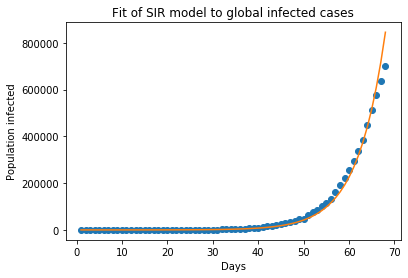

Optimal parameters: beta = 2.8388775118022087  and gamma =  2.6704030076887997


In [25]:
plt.plot(x, y, 'o')
plt.plot(x, fitted)
plt.title("Fit of SIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", beta_hat[0], " and gamma = ", beta_hat[1])

In [26]:
# beta, gamma = popt[0], popt[1]
beta, gamma = beta_hat[0], beta_hat[1]

In [27]:
y0 = S0, I0, R0
ret = odeint(SIR, y0, X, args=(N, beta, gamma))

S, I, R = ret.T


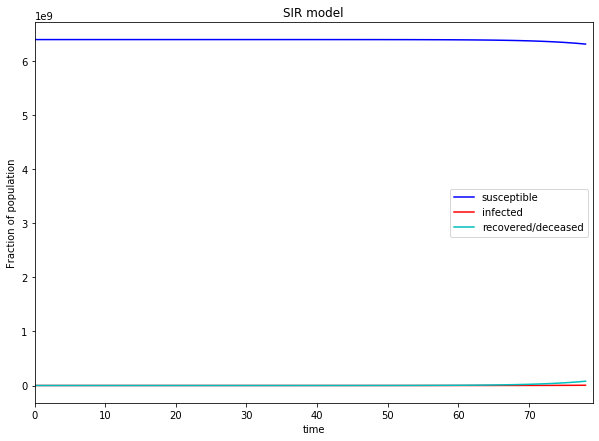

In [28]:
f = plt.figure(figsize=(10,7)) 
plt.plot(S, 'b', label='susceptible');
plt.plot(I, 'r', label='infected');
plt.plot(R, 'c', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,len(X))
plt.show()

In [29]:
y0 = S0, I0, R0
ret = odeint(SIR, y0, [i for i in range(100)], args=(N, beta, gamma))

S, I, R = ret.T

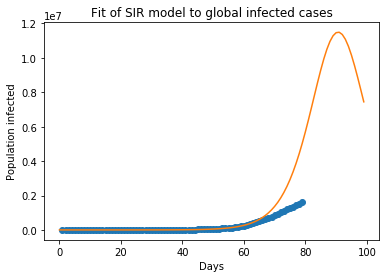

In [30]:
plt.plot(X, Y, 'o')
plt.plot([i for i in range(100)], I)
plt.title("Fit of SIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()

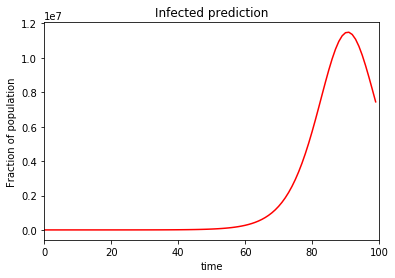

In [31]:
plt.plot(I, 'r', label='infected');
plt.title("Infected prediction")
plt.xlabel("time");
plt.ylabel("Fraction of population");
plt.xlim(0,100)
plt.show()

In [32]:
max(I)

11491063.37561974

In [33]:
max(df['Confirmed'].values)

1608778

In [34]:
lim = len(Y)
# mse = mean_squared_error(y, I[:lim])
rmsle = math.sqrt(mean_squared_log_error(Y[index:], I[index:lim]))
print(rmsle)

0.6667019443887245


# SEIR model

In [35]:
# Total population, N without china
N = 6.4 *(10**9)
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0, E0 = 1, 0, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0 - E0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma, sigma = 0.6, 1/10, 0.1

In [36]:
# The SEIR model differential equations.
def SEIR(y, t, N, beta, gamma, sigma):
    S, E, I, R = y
    dSdt = (-beta * S * I) / N
    dEdt = ((beta * S * I) / N) - (sigma * E) 
    dIdt = (sigma * E) - (gamma * I)
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt


In [37]:
# Initial conditions vector
y0 = S0, E0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(SEIR, y0, [i for i in range(1000)], args=(N, beta, gamma, sigma))

S, E, I, R = ret.T


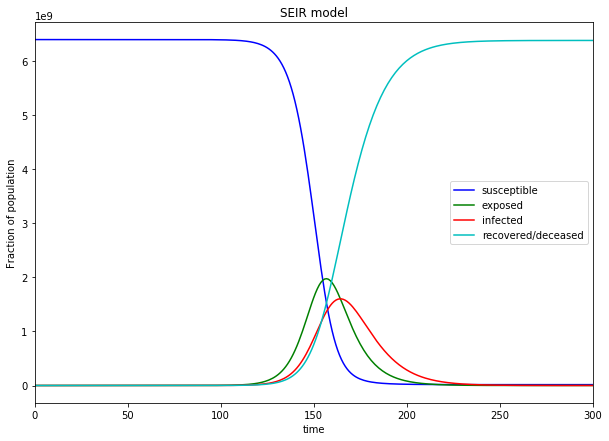

In [38]:
f = plt.figure(figsize=(10,7)) 
plt.plot(S, 'b', label='susceptible');
plt.plot(E, 'g', label='exposed');
plt.plot(I, 'r', label='infected');
plt.plot(R, 'c', label='recovered/deceased');
plt.title("SEIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,300)
plt.show()

In [39]:
train = 0.8
index = math.ceil(train * len(df['Confirmed'].values))
index

64

In [40]:
Y = df['Confirmed'].values
X = df['Day num'].values

In [41]:
y = df['Confirmed'].values[:index]
x = df['Day num'].values[:index]

N = int(pop[pop['Country/Region'] != 'China']['Population'].sum())
I0, R0, E0 = y[0], 0, 0
S0 = N - I0 - R0 - E0

In [42]:
def opt_seir(x, beta, gamma, sigma):
    return odeint(SEIR, (S0, E0, I0, R0), x, args=(N, beta, gamma, sigma))[:,1].clip(0)

def err_seir(params, x):
    beta, gamma, sigma = params
    ret = odeint(SEIR, (S0, E0, I0, R0), x, args=(N, beta, gamma, sigma))
    S, E, I, R = ret.T
    I = I.clip(0)
    error = np.sqrt(mean_squared_log_error(y, I, [1/i for i in x][::-1]))
    return error
    

In [43]:
# np.array(x)

In [44]:
popt, pcov = optimize.curve_fit(opt_seir, x, y, bounds = [0, np.inf])

result = optimize.minimize(err_seir, popt, args=(x), method='BFGS', options={'maxiter': 500})

beta_hat = result.x
print(result)


      fun: 0.1779742923341726
 hess_inv: array([[0.03820782, 0.0223485 , 0.0028333 ],
       [0.0223485 , 0.01716363, 0.00214749],
       [0.0028333 , 0.00214749, 0.0002692 ]])
      jac: array([-0.0018614 , -0.02605714,  0.24275357])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 461
      nit: 12
     njev: 90
   status: 2
  success: False
        x: array([ 1.41694035, -0.23355966, -0.00800671])


In [45]:
# pcov

In [46]:
# fitted = opt_ode(x, *popt)
# fitted = opt_ode(x, *beta_hat)
y0 = S0, E0, I0, R0
ret = odeint(SEIR, y0, X, args=(N, *beta_hat))
# ret = odeint(deriv, y0, X, args=(N, *popt))

S, E, I, R = ret.T


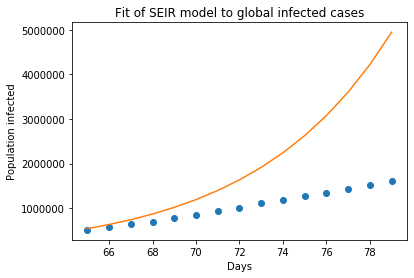

Optimal parameters: beta = 1.4169403524771214 , gamma =  -0.23355965809616736 , sigma =  -0.008006710918230724


In [47]:
plt.plot(X[index:], Y[index:], 'o')
plt.plot(X[index:], I[index:])
plt.title("Fit of SEIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", beta_hat[0], ", gamma = ", beta_hat[1],", sigma = ", beta_hat[2] )

In [48]:
# beta, gamma, sigma = popt[0], popt[1], popt[2]
beta, gamma, sigma = beta_hat[0], beta_hat[1], beta_hat[2]

In [49]:
y0 = S0, E0, I0, R0
ret = odeint(SEIR, y0, [i for i in range(200)], args=(N, beta, gamma, sigma))

S, E, I, R = ret.T


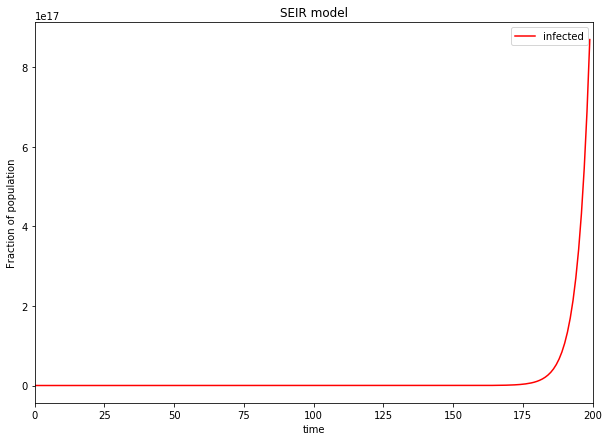

In [50]:
f = plt.figure(figsize=(10,7)) 
# plt.plot(S, 'b.', label='susceptible');
# plt.plot(E, 'g.', label='Exposed');
plt.plot(I, 'r', label='infected');
# plt.plot(R, 'c.', label='recovered/deceased');
plt.title("SEIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,200)
plt.show()

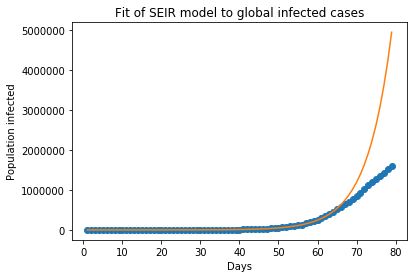

In [51]:
plt.plot(X, Y, 'o')
plt.plot(X, I[:len(Y)])
plt.title("Fit of SEIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()

In [52]:
lim = len(y)
mse = mean_squared_error(y, I[:lim])
rmsle = (mean_squared_log_error(Y, I[:len(Y)]))
print(rmsle)

0.16162758917279205


In [53]:
# [1/i for i in x][::-1]

In [54]:
max(I)

8.693874235643904e+17

# SIQR model

In [55]:
# Total population, N without china
N = 6.4 *(10**9)
I0, R0, Q0 = 10, 0, 0
S0 = N - I0 - R0 - Q0
beta, gamma, alpha, theta = 2.0, 1/10, 1.0, 0.3

In [56]:
# The SIQR model differential equations.

def SIQR(y, t, N, alpha, beta, gamma, theta):
    S, I, Q, R = y
    dSdt = (-beta * S * I) / N
    dIdt = ((beta * S * I) / N) - ((theta + alpha) * I)
    dQdt = (theta * I) - (gamma * Q) 
    dRdt = (alpha * I) + (gamma * Q)
    return dSdt, dIdt, dQdt, dRdt


In [57]:
# Initial conditions vector
y0 = S0, I0, Q0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(SIQR, y0, [i for i in range(100)], args=(N, alpha, beta, gamma, theta))

S, I, Q, R = ret.T


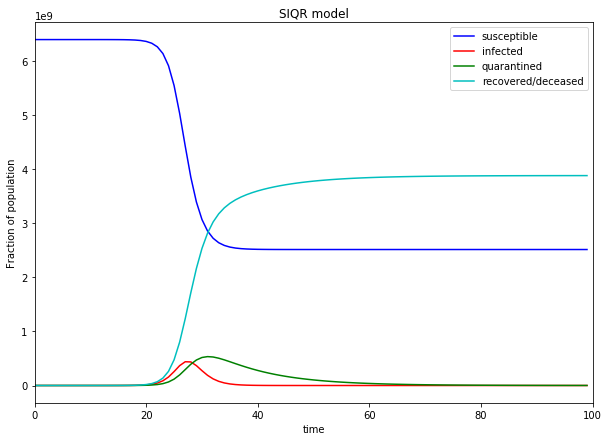

In [58]:
f = plt.figure(figsize=(10,7)) 
plt.plot(S, 'b', label='susceptible');
plt.plot(I, 'r', label='infected');
plt.plot(Q, 'g', label='quarantined');
plt.plot(R, 'c', label='recovered/deceased');
plt.title("SIQR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,100)
plt.show()

In [59]:
train = 0.8
index = math.ceil(train * len(df['Confirmed'].values))
index

64

In [60]:
Y = df['Confirmed'].values
X = df['Day num'].values

In [61]:
y = df['Confirmed'].values[:index]
x = df['Day num'].values[:index]

N = int(pop[pop['Country/Region'] != 'China']['Population'].sum())
I0, R0, Q0 = y[0], 0, 0
S0 = N - I0 - R0 - Q0

In [62]:
# S0

In [63]:
def opt_siqr(x, alpha, beta, gamma, theta):
    return odeint(SIQR, (S0, I0, Q0, R0), x, args=(N, alpha, beta, gamma, theta))[:,1].clip(0)

def err_siqr(params, x):
    alpha, beta, gamma, theta = params
    ret = odeint(SIQR, (S0, I0, Q0, R0), x, args=(N, alpha, beta, gamma, theta))
    S, I, Q, R = ret.T
    I = I.clip(0)
    error = np.sqrt(mean_squared_log_error(y, I, [1/i for i in x][::-1]))
    return error
    

In [64]:
# np.array(x)

In [65]:
popt, pcov = optimize.curve_fit(opt_siqr, x, y, bounds = [0, np.inf])

result = optimize.minimize(err_siqr, popt, args=(x), method='BFGS', options={'maxiter': 500})

beta_hat = result.x
print(beta_hat)


[ 9.21398283 10.95066059 -7.93045902  1.56278848]


In [66]:
# pcov

In [67]:
# fitted = opt_ode(x, *popt)
# fitted = opt_ode(x, *beta_hat)
y0 = S0, I0, Q0, R0
ret = odeint(SIQR, y0, X, args=(N, *beta_hat))
# ret = odeint(deriv, y0, X, args=(N, *popt))

S, I, Q, R = ret.T


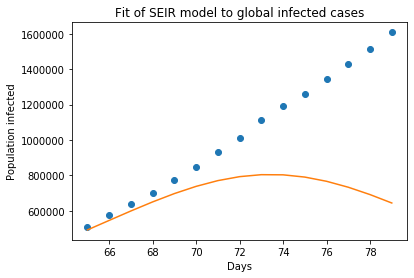

Optimal parameters: beta = 9.213982832684176 , gamma =  10.950660587331393 , sigma =  -7.93045901807241


In [68]:
plt.plot(X[index:], Y[index:], 'o')
plt.plot(X[index:], I[index:])
plt.title("Fit of SEIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", beta_hat[0], ", gamma = ", beta_hat[1],", sigma = ", beta_hat[2] )

In [69]:
# beta, gamma, sigma, theta = popt[0], popt[1], popt[2], popt[3]
alpha, beta, gamma, theta = beta_hat[0], beta_hat[1], beta_hat[2], beta_hat[3]

In [70]:
y0 = S0, I0, Q0, R0
ret = odeint(SIQR, y0, [i for i in range(300)], args=(N, alpha, beta, gamma, theta))

S, I, Q, R = ret.T


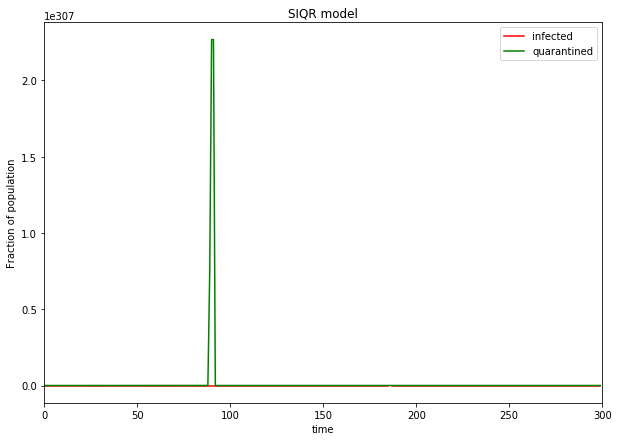

In [71]:
f = plt.figure(figsize=(10,7)) 
# plt.plot(S, 'b', label='susceptible');
plt.plot(I, 'r', label='infected');
plt.plot(Q, 'g', label='quarantined');
# plt.plot(R, 'c', label='recovered/deceased');
plt.title("SIQR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,300)
plt.show()

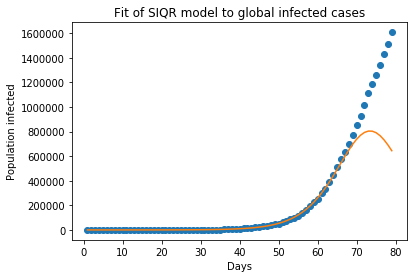

In [72]:
plt.plot(X, Y, 'o')
plt.plot(X, I[:len(Y)])
plt.title("Fit of SIQR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()

In [73]:
lim = len(y)
mse = mean_squared_error(y, I[:lim])
rmsle = (mean_squared_log_error(Y, I[:len(Y)]))
print(rmsle)

0.17320832507337106


# SEIR with social distancing

In [74]:
# Total population, N without china
N = 6.4 *(10**9)
I0, R0, E0 = 1, 0, 0
S0 = N - I0 - R0 - E0
beta, gamma, sigma, alpha = 1.75, 0.5, 0.2, 0.5

In [75]:
# The SIR model differential equations.
def SEIRsd(y, t, N, beta, gamma, sigma, alpha):
    S, E, I, R = y
    dSdt = (-alpha * beta * S * I) / N
    dEdt = ((alpha * beta * S * I) / N) - (sigma * E) 
    dIdt = (sigma * E) - (gamma * I)
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt


In [76]:
# Initial conditions vector
y0 = S0, E0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(SEIRsd, y0, [i for i in range(1000)], args=(N, beta, gamma, sigma, alpha))

S, E, I, R = ret.T


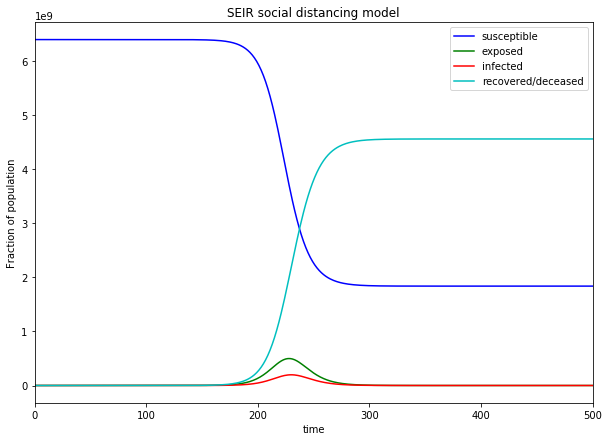

In [77]:
f = plt.figure(figsize=(10,7)) 
plt.plot(S, 'b', label='susceptible');
plt.plot(E, 'g', label='exposed');
plt.plot(I, 'r', label='infected');
plt.plot(R, 'c', label='recovered/deceased');
plt.title("SEIR social distancing model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,500)
plt.show()

## Comparison with and without social distancing

In [78]:
y0 = S0, E0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret1 = odeint(SEIR, y0, [i for i in range(1000)], args=(N, beta, gamma, sigma))

S1, E1, I1, R1 = ret1.T

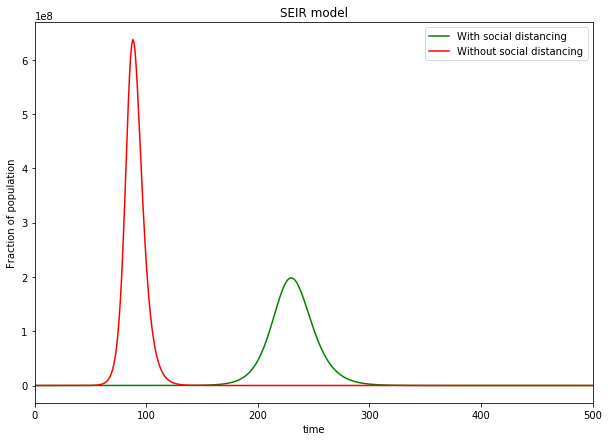

In [79]:
f = plt.figure(figsize=(10,7)) 
# plt.plot(S, 'b', label='susceptible');
plt.plot(I, 'g', label='With social distancing');
plt.plot(I1, 'r', label='Without social distancing');
# plt.plot(R, 'c', label='recovered/deceased');
plt.title("SEIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,500)
plt.show()

In [80]:
train = 0.8
index = math.ceil(train * len(df['Confirmed'].values))
index

64

In [81]:
Y = df['Confirmed'].values
X = df['Day num'].values

In [82]:
y = df['Confirmed'].values
x = df['Day num'].values

N = int(pop[pop['Country/Region'] != 'China']['Population'].sum())
I0, R0, E0 = y[0], 0, 0
S0 = N - I0 - R0 - E0

In [83]:
def opt_seirsd(x, beta, gamma, sigma, alpha):
#     if alpha > 1:
#         alpha = 1
#     elif alpha < 0:
#         alpha = 0
    return odeint(SEIRsd, (S0, E0, I0, R0), x, args=(N, beta, gamma, sigma, alpha))[:,1].clip(0)

def err_seirsd(params, x):
    beta, gamma, sigma, alpha = params
#     if alpha > 1:
#         alpha = 1
#     elif alpha < 0:
#         alpha = 0
    ret = odeint(SEIRsd, (S0, E0, I0, R0), x, args=(N, beta, gamma, sigma, alpha))
    S, E, I, R = ret.T
    I = I.clip(0)
    error = np.sqrt(mean_squared_log_error(y, I, [1/i for i in x][::-1]))
    return error
    

In [84]:
# np.array(x)

In [85]:
popt, pcov = optimize.curve_fit(opt_seirsd, x, y, bounds = [0, np.inf])

result = optimize.minimize(err_seirsd, popt, args=(x), method='BFGS', options={'maxiter': 1000})

beta_hat = result.x
print(result)


      fun: 0.5186267707715446
 hess_inv: array([[ 0.50046215,  0.00059614, -0.00148119, -0.49953785],
       [ 0.00059614,  0.00087627, -0.00198129,  0.00059614],
       [-0.00148119, -0.00198129,  0.0047938 , -0.00148119],
       [-0.49953785,  0.00059614, -0.00148119,  0.50046215]])
      jac: array([-0.1345116 ,  0.04331589, -0.06275629, -0.1345116 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 785
      nit: 46
     njev: 129
   status: 2
  success: False
        x: array([0.56712112, 0.1347559 , 1.7991293 , 0.56712112])


In [86]:
# pcov

In [87]:
# fitted = opt_ode(x, *popt)
# fitted = opt_ode(x, *beta_hat)
y0 = S0, E0, I0, R0
ret = odeint(SEIRsd, y0, X, args=(N, *beta_hat))
# ret = odeint(deriv, y0, X, args=(N, *popt))

S, E, I, R = ret.T


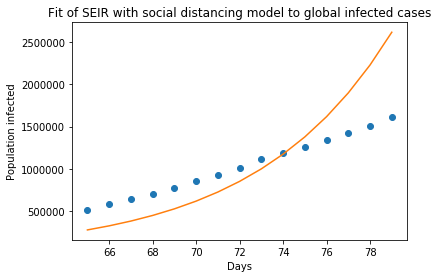

Optimal parameters: beta = 1.1761691603561033 , gamma =  0.9465481849047802 , sigma =  0.6408328571270568


In [88]:
plt.plot(X[index:], Y[index:], 'o')
plt.plot(X[index:], I[index:])
plt.title("Fit of SEIR with social distancing model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], ", gamma = ", popt[1],", sigma = ", popt[2] )

In [89]:
# beta, gamma, sigma = popt[0], popt[1], popt[2]
beta, gamma, sigma, alpha = beta_hat[0], beta_hat[1], beta_hat[2], beta_hat[3]

In [90]:
y0 = S0, E0, I0, R0
ret = odeint(SEIRsd, y0, [i for i in range(500)], args=(N, beta, gamma, sigma, alpha))

S, E, I, R = ret.T


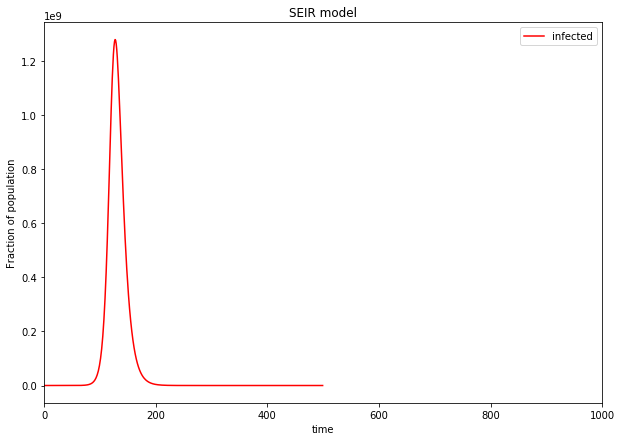

In [91]:
f = plt.figure(figsize=(10,7)) 
# plt.plot(S, 'b.', label='susceptible');
# plt.plot(E, 'g.', label='Exposed');
plt.plot(I, 'r', label='infected');
# plt.plot(R, 'c.', label='recovered/deceased');
plt.title("SEIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,1000)
plt.show()

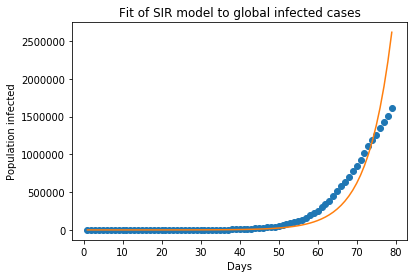

In [92]:
plt.plot(X, Y, 'o')
plt.plot(X, I[:len(Y)])
plt.title("Fit of SIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()

In [93]:
lim = len(y)
mse = mean_squared_error(y, I[:lim])
rmsle = (mean_squared_log_error(Y, I[:len(Y)]))
print(rmsle)

0.48235250581905675


# Analysing each country individualy

In [94]:
df_c.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [95]:
df_c = df_c.replace('US', 'United States').replace('Korea, South', 'South Korea')

In [96]:
countries = list(set(df_c['Country/Region'].values).intersection(set(pop['Country/Region'].values)))
# len(countries)

In [97]:
countries[64]

'Mauritania'

In [98]:
errs_sir = []
for country in tqdm(countries):
    temp = df_c[df_c['Country/Region'] == country].reset_index()
    temp = temp[temp['Confirmed'] > 0].fillna(0)
    temp['Day num'] = np.arange(1, len(temp)+1)
    
    N = int(pop[pop['Country/Region'] == country]['Population'])
    
    train = 0.8
    index = math.ceil(train * len(temp['Confirmed'].values))
    Y = temp['Confirmed'].values
    X = temp['Day num'].values
    
    y = temp['Confirmed'].values[:index]
    x = temp['Day num'].values[:index]
    
    try:
        I0, R0 = y[0], 0
        S0 = N - I0 - R0

        popt, pcov = optimize.curve_fit(opt_sir, x, y, bounds = [0, np.inf])
        result = optimize.minimize(err_sir, popt, args=(x), method='BFGS', options={'maxiter': 500})
        beta_hat = result.x
        fitted = opt_sir(X, *beta_hat)
        
    except:
        I0, R0, E0 = y[0], 0, 0
        S0 = N - I0 - R0 - E0
        popt, pcov = optimize.curve_fit(opt_seir, x, y, bounds = [0, np.inf])
        result = optimize.minimize(err_seir, popt, args=(x), method='BFGS', options={'maxiter': 500})
        beta_hat = result.x

        fitted = opt_seir(X, *beta_hat)
    
    if len(Y[index:]) > 0 and len(fitted[index:]) > 0:
        rmsle = np.sqrt(mean_squared_log_error(Y[index:], fitted[index:]))
        errs_sir.append(rmsle)

In [99]:
np.array(errs_sir).mean()

0.6775516565323072

In [100]:
# errs_sir

In [101]:
errs_seir = []
for country in tqdm(countries):
    temp = df_c[df_c['Country/Region'] == country].reset_index()
    temp = temp[temp['Confirmed'] > 0].fillna(0)
    temp['Day num'] = np.arange(1, len(temp)+1)
    
    N = int(pop[pop['Country/Region'] == country]['Population'])
    
    train = 0.8
    index = math.ceil(train * len(temp['Confirmed'].values))
    Y = temp['Confirmed'].values
    X = temp['Day num'].values
    
    y = temp['Confirmed'].values[:index]
    x = temp['Day num'].values[:index]
    
    try:
        I0, R0, E0 = y[0], 0, 0
        S0 = N - I0 - R0 - E0
        popt, pcov = optimize.curve_fit(opt_seir, x, y, bounds = [0, np.inf])
        result = optimize.minimize(err_seir, popt, args=(x), method='BFGS', options={'maxiter': 500})
        beta_hat = result.x

        fitted = opt_seir(X, *beta_hat)
    except:
        I0, R0 = y[0], 0
        S0 = N - I0 - R0

        popt, pcov = optimize.curve_fit(opt_sir, x, y, bounds = [0, np.inf])
        result = optimize.minimize(err_sir, popt, args=(x), method='BFGS', options={'maxiter': 500})
        beta_hat = result.x

        fitted = opt_sir(X, *beta_hat)
    
    if len(Y[index:]) > 0 and len(fitted[index:]) > 0:
        rmsle = np.sqrt(mean_squared_log_error(Y[index:], fitted[index:]))
        errs_seir.append(rmsle)

In [102]:
np.array(errs_seir).mean()

3.6991125529048556

In [103]:
# errs_seir

In [104]:
errs_siqr = []
for country in tqdm(countries):
    temp = df_c[df_c['Country/Region'] == country].reset_index()
    temp = temp[temp['Confirmed'] > 0].fillna(0)
    temp['Day num'] = np.arange(1, len(temp)+1)
    
    N = int(pop[pop['Country/Region'] == country]['Population'])
    
    train = 0.8
    index = math.ceil(train * len(temp['Confirmed'].values))
    Y = temp['Confirmed'].values
    X = temp['Day num'].values
    
    y = temp['Confirmed'].values[:index]
    x = temp['Day num'].values[:index]

    try:
        I0, R0, Q0 = y[0], 0, 0
        S0 = N - I0 - R0 - Q0

        popt, pcov = optimize.curve_fit(opt_siqr, x, y, bounds = [0, np.inf])
        result = optimize.minimize(err_siqr, popt, args=(x), method='BFGS', options={'maxiter': 500})
        beta_hat = result.x
        fitted = opt_siqr(X, *beta_hat)
    except:
        I0, R0, E0 = y[0], 0, 0
        S0 = N - I0 - R0 - E0
        popt, pcov = optimize.curve_fit(opt_seir, x, y, bounds = [0, np.inf])
        result = optimize.minimize(err_seir, popt, args=(x), method='BFGS', options={'maxiter': 500})
        beta_hat = result.x

        fitted = opt_seir(X, *beta_hat)
    
    if len(Y[index:]) > 0 and len(fitted[index:]) > 0:
        rmsle = np.sqrt(mean_squared_log_error(Y[index:], fitted[index:]))
        errs_siqr.append(rmsle)

In [105]:
np.array(errs_siqr).mean()

0.7241865222580777

In [106]:
errs_seirsd = []
for country in tqdm(countries):
    temp = df_c[df_c['Country/Region'] == country].reset_index()
    temp = temp[temp['Confirmed'] > 0].fillna(0)
    temp['Day num'] = np.arange(1, len(temp)+1)
    
    N = int(pop[pop['Country/Region'] == country]['Population'])
    
    train = 0.8
    index = math.ceil(train * len(temp['Confirmed'].values))
    Y = temp['Confirmed'].values
    X = temp['Day num'].values
    
    y = temp['Confirmed'].values[:index]
    x = temp['Day num'].values[:index]

    I0, R0, E0 = y[0], 0, 0
    S0 = N - I0 - R0 - E0
    
    popt, pcov = optimize.curve_fit(opt_seirsd, x, y, bounds = [0, np.inf])
    result = optimize.minimize(err_seirsd, popt, args=(x), method='BFGS', options={'maxiter': 500})
    beta_hat = result.x
    
    fitted = opt_seirsd(X, *beta_hat)
    if len(Y[index:]) > 0 and len(fitted[index:]) > 0:
        rmsle = np.sqrt(mean_squared_log_error(Y[index:], fitted[index:]))
        errs_seirsd.append(rmsle)

In [107]:
np.array(errs_seirsd).mean()

4.138724756772545

In [109]:
# plt.plot(x, y, 'o')
# plt.plot(x, fitted)
# plt.title("Fit of SIR model to global infected cases")
# plt.ylabel("Population infected")
# plt.xlabel("Days")
# plt.show()
# print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])